In [59]:
import torch
import torch.nn.functional as F
import torchaudio
import math
from torchaudio.functional import lfilter
import matplotlib.pyplot as plt
from IPython.display import Audio
import diffsptk
from itertools import accumulate
from tqdm import tqdm

In [167]:
!wget "http://festvox.org/cmu_arctic/cmu_arctic/cmu_us_awb_arctic/wav/arctic_a0007.wav"

--2023-10-27 17:24:34--  http://festvox.org/cmu_arctic/cmu_arctic/cmu_us_awb_arctic/wav/arctic_a0007.wav
Resolving festvox.org (festvox.org)... 199.4.150.153
Connecting to festvox.org (festvox.org)|199.4.150.153|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128044 (125K) [audio/x-wav]
Saving to: ‘arctic_a0007.wav’

arctic_a0007.wav    100%[===================>] 125.04K   319KB/s    in 0.4s    

2023-10-27 17:24:35 (319 KB/s) - ‘arctic_a0007.wav’ saved [128044/128044]



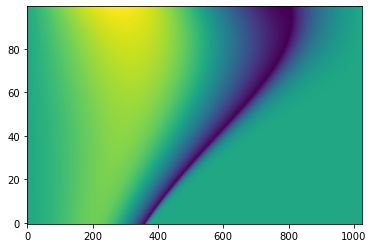

In [2]:
def transformed_lf(Rd: torch.Tensor, points: int = 1024):
    Rd = torch.as_tensor(Rd).view(-1, 1)
    Ra = -0.01 + 0.048 * Rd
    Rk = 0.224 + 0.118 * Rd
    Rg = (Rk / 4) * (0.5 + 1.2 * Rk) / (0.11 * Rd - Ra * (0.5 + 1.2 * Rk))

    Ta = Ra
    Tp = 1 / (2 * Rg)
    Te = Tp + Tp * Rk

    epsilon = 1 / Ta
    shift = torch.exp(-epsilon * (1 - Te))
    delta = 1 - shift

    rhs_integral = (1 / epsilon) * (shift - 1) + (1 - Te) * shift
    rhs_integral /= delta

    lower_integral = -(Te - Tp) / 2 + rhs_integral
    upper_integral = -lower_integral

    omega = torch.pi / Tp
    s = torch.sin(omega * Te)
    y = -torch.pi * s * upper_integral / (Tp * 2)
    z = torch.log(y)
    alpha = z / (Tp / 2 - Te)
    EO = -1 / (s * torch.exp(alpha * Te))

    t = torch.linspace(0, 1, points + 1)[None, :-1]
    before = EO * torch.exp(alpha * t) * torch.sin(omega * t)
    after = (
        (-torch.exp(-epsilon * (t - Te)) + shift) / delta
    )
    return torch.where(t < Te, before, after)

table = transformed_lf(torch.exp(torch.linspace(math.log(0.3), math.log(2.7), 100)))

plt.imshow(table, aspect='auto', origin='lower')
plt.show()

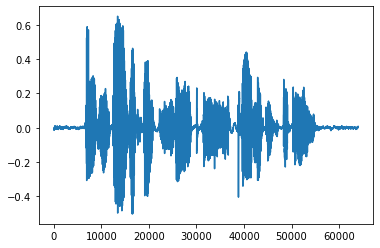

In [168]:
y, sr = torchaudio.load('arctic_a0007.wav')

# Plot the waveform
plt.figure()
plt.plot(y.squeeze().numpy())
# plt.xlim(24000, 25000)
plt.show()

Audio(y.numpy(), rate=sr)

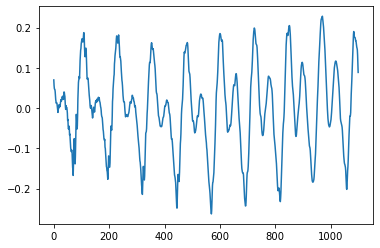

In [333]:
target = y[0, 9900:11000]

plt.plot(target.numpy())
plt.show()

In [371]:
def get_forward(lpc_order, table_points=1024, num_tables=100):
    # create variables that does not change over time
    table = transformed_lf(
        torch.exp(torch.linspace(math.log(0.3), math.log(2.7), num_tables)),
        points=table_points,
    )
    logits2lpc = torch.nn.Sequential(
        diffsptk.LogAreaRatioToParcorCoefficients(lpc_order),
        diffsptk.ParcorCoefficientsToLinearPredictiveCoefficients(lpc_order),
    )

    def forward(steps: int, f0, log_gain, log_area_ratios, R_d_index, offset):
        # generate the source, glottal pulse

        select_index = R_d_index * (num_tables - 1)
        select_index_floor = select_index.long().item()
        p = select_index - select_index_floor
        selected_table = (
            table[select_index_floor] * (1 - p) + table[select_index_floor + 1] * p
        )

        phase = (
            torch.arange(steps, device=f0.device, dtype=f0.dtype) / sr * f0 + offset
        ) % 1
        phase_index = phase * table_points
        padded_table = torch.cat([selected_table, selected_table[:1]])
        phase_index_floor = phase_index.long()
        phase_index_ceil = phase_index_floor + 1
        p = phase_index - phase_index_floor
        glottal_pulse = (
            padded_table[phase_index_floor] * (1 - p)
            + padded_table[phase_index_ceil] * p
        )

        log_gain, lpc_coeffs = logits2lpc(torch.cat([log_gain, log_area_ratios])).split(
            [1, lpc_order]
        )
        b = log_gain.new_zeros(1 + lpc_coeffs.shape[-1])
        b[0] = torch.exp(log_gain)
        a = torch.cat([lpc_coeffs.new_ones(1), lpc_coeffs])

        return lfilter(glottal_pulse, a, b, clamp=False)

    return forward

In [376]:
order = 20
foword_call = get_forward(order)

steps = 1100
f0 = torch.tensor([130.0]).requires_grad_(True)
log_gain = torch.tensor([-1.3]).requires_grad_(True)
log_area_ratios = torch.zeros(order).requires_grad_(True)
# lpc_coeffs = torch.zeros(order).requires_grad_(True)
R_d_index_logits = torch.tensor([.0]).requires_grad_(True)
offset = torch.tensor([0.]).requires_grad_(True)

tensor([130.3820], requires_grad=True) tensor([-1.6566], requires_grad=True) tensor([ 0.3147,  0.2503,  0.1317, -0.0305, -0.1720, -0.2650, -0.3286, -0.3597,
        -0.3637, -0.3419, -0.2850, -0.1698,  0.0264,  0.2322,  0.3716,  0.4533,
         0.4958,  0.5144,  0.5196,  0.5176], requires_grad=True) tensor([0.6866]) tensor([0.1422], requires_grad=True)


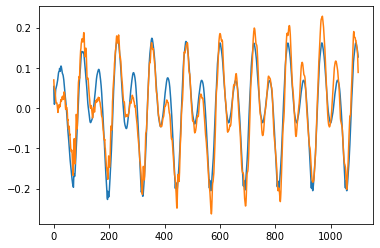

In [380]:
with torch.no_grad():
    output = foword_call(steps, f0, log_gain, log_area_ratios, R_d_index_logits.sigmoid(), offset)
    print(f0, log_gain, log_area_ratios, R_d_index_logits.sigmoid(), offset)
    # output = foword_call(steps, f0, log_gain, lpc_coeffs, R_d_index_logits.sigmoid(), offset)
    # print(f0, log_gain, lpc_coeffs, R_d_index_logits.sigmoid(), offset)

plt.plot(output.numpy())
plt.plot(target.numpy())
plt.show()

In [378]:
optimizer = torch.optim.Adam(
    [f0, log_gain, log_area_ratios, R_d_index_logits, offset], lr=0.001
)

with tqdm(range(1000)) as pbar:
    for _ in pbar:
        optimizer.zero_grad()
        output = foword_call(steps, f0, log_gain, log_area_ratios, R_d_index_logits.sigmoid(), offset)
        loss = F.l1_loss(output, target)
        loss.backward()
        optimizer.step()
        
        pbar.set_description(f'loss: {loss.item():.4f}')



loss: 0.0295: 100%|██████████| 1000/1000 [00:07<00:00, 137.54it/s]
